In [1]:
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
from meld_classifier.define_features import Feature
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH,MELD_DATA_PATH
import sklearn.metrics as metrics
from sklearn import neural_network

Setting MELD_DATA_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/output/preprocessed_surf_data
Setting EXPERIMENT_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/models
Setting FS_SUBJECTS_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/output/fs_outputs


In [3]:
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset="MELD_dataset_V6.csv",
             data_dir=MELD_DATA_PATH)

In [4]:
# get all patients and controls
patient_ids = cohort.get_subject_ids(group='patient')
control_ids = cohort.get_subject_ids(group='control')
print(len(patient_ids), 'patients', len(control_ids), 'controls')

# get all features
for f in cohort.full_feature_list:
    print(f)

538 patients 373 controls
.combat.on_lh.curv.sm5.mgh
.combat.on_lh.gm_FLAIR_0.25.sm10.mgh
.combat.on_lh.gm_FLAIR_0.5.sm10.mgh
.combat.on_lh.gm_FLAIR_0.75.sm10.mgh
.combat.on_lh.gm_FLAIR_0.sm10.mgh
.combat.on_lh.pial.K_filtered.sm20.mgh
.combat.on_lh.sulc.sm5.mgh
.combat.on_lh.thickness.sm10.mgh
.combat.on_lh.w-g.pct.sm10.mgh
.combat.on_lh.wm_FLAIR_0.5.sm10.mgh
.combat.on_lh.wm_FLAIR_1.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh
.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh
.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh
.

In [47]:
def get_subject_features(subject_ids, feature, cohort):
    """
    preload features from controls for a list of controls
    """
    n_vert = sum(cohort.cortex_mask)
    subject_data = {'features':{}, 'lesions': {}}
    subject_data['features']= np.zeros((len(subject_ids),2*n_vert))
    subject_data['lesions']= np.zeros((len(subject_ids),2*n_vert))
    for s,sid in enumerate(subject_ids):
        subj = MeldSubject(sid, cohort)
        for h,hemi in enumerate(['lh', 'rh']):
            features,lesion = subj.load_feature_lesion_data([feature], hemi=hemi)
            subject_data['features'][s,h*n_vert:(h+1)*n_vert] = features[cohort.cortex_mask].flatten()
            subject_data['lesions'][s,h*n_vert:(h+1)*n_vert] = lesion[cohort.cortex_mask]>0        
    return subject_data


def get_auc(all_features, bootstrap=False, classifier=True):
    subj_ids = np.arange(len(all_features['features']))
    y_score = all_features['features'][subj_ids].ravel()
    label = all_features['lesions'][subj_ids].ravel()
    if classifier:
        clf = neural_network.MLPClassifier(hidden_layer_sizes=[2],random_state=1, max_iter=3,
                                          verbose=True).fit(y_score.reshape(-1, 1), label)
    if bootstrap:
        #randomly with replacement
        scores=[]
        for b in np.arange(bootstrap):
            subj_ids = np.arange(len(all_features['features']))
            subj_ids = np.random.choice(len(subj_ids),len(subj_ids))
            y_score = all_features['features'][subj_ids].ravel()
            label = all_features['lesions'][subj_ids].ravel()
            pred = clf.predict_proba(y_score.reshape(-1, 1))
            score = metrics.roc_auc_score(label, pred[:,1])
            scores.append(score)
        return scores
    else:
        pred = clf.predict_proba(y_score.reshape(-1, 1))
        score = metrics.roc_auc_score(label, pred[:,1])
        return [score]


def get_auc_for_features(subject_ids, features, cohort, bootstrap =False):
    """
    calculate tstats for all patients + matching controls for all features in features dict
    """
    import time
    stats_c = {}
    for ftype, fdict in features.items():
        cur_stats_c = {}
        stats_c[ftype]=[]
        for fname, feature in fdict.items():
            subj_data = get_subject_features(subject_ids, feature, cohort)
            
            bootstrap_stats = get_auc(subj_data, bootstrap=bootstrap)
            cur_stats_c[fname]=np.array(bootstrap_stats)
        stats_c[ftype].append(cur_stats_c)
    return stats_c

In [48]:
#cohort.full_feature_list

## compare combat vs asym for noFLAIR features

In [49]:
# set up data for comparing combat vs asym features (no FLAIR features)
base_features = [
    '.on_lh.curv.mgh',
    '.on_lh.pial.K_filtered.mgh',
    '.on_lh.sulc.mgh',
   '.on_lh.thickness.mgh',
    '.on_lh.w-g.pct.mgh',
    ]
smooth = [5, 20, 5, 10, 10]

# build feature names for comparing combat vs asym
features = {
    'combat': {f:Feature(f, sm).get_combat_feature() for f,sm in zip(base_features, smooth)},
    'asym': {f:Feature(f, sm).get_asym_feature() for f,sm in zip(base_features, smooth)},
    'inter': {f:Feature(f, sm).get_norm_feature() for f,sm in zip(base_features, smooth)}
    
}
print(features)

# choose random controls to compare against
cur_control_ids = np.random.choice(control_ids, size=50, replace=False)

# Q: for FLAIR, choose only patients + controls that have flair
# Q: match scanner strength for patients + controls?

{'combat': {'.on_lh.curv.mgh': '.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.combat.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.mgh': '.combat.on_lh.w-g.pct.sm10.mgh'}, 'asym': {'.on_lh.curv.mgh': '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.mgh': '.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh'}, 'inter': {'.on_lh.curv.mgh': '.inter_z.intra_z.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.inter_z.intra_z.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.inter_z.intra_z.combat.on_lh.thickness.sm10.mg

In [56]:
ids = np.hstack([patient_ids,cur_control_ids])
ids = np.random.choice(ids,200)
dict_scores=get_auc_for_features(ids, features, cohort,bootstrap = 10 )


Iteration 1, loss = 0.04641604
Iteration 2, loss = 0.04513352
Iteration 3, loss = 0.04513372


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04399866
Iteration 2, loss = 0.04348202
Iteration 3, loss = 0.04348162


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04570459
Iteration 2, loss = 0.04514215
Iteration 3, loss = 0.04514169


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04389695
Iteration 2, loss = 0.04364123
Iteration 3, loss = 0.04364000


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04454629
Iteration 2, loss = 0.04443538
Iteration 3, loss = 0.04443508


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04577119
Iteration 2, loss = 0.04513730
Iteration 3, loss = 0.04513698


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04406422
Iteration 2, loss = 0.04346979
Iteration 3, loss = 0.04346843


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04574149
Iteration 2, loss = 0.04510395
Iteration 3, loss = 0.04510352


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04519801
Iteration 2, loss = 0.04454230
Iteration 3, loss = 0.04454118


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04291944
Iteration 2, loss = 0.04230200
Iteration 3, loss = 0.04230094


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04578229
Iteration 2, loss = 0.04512716
Iteration 3, loss = 0.04512649


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04350393
Iteration 2, loss = 0.04282479
Iteration 3, loss = 0.04282401


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04567889
Iteration 2, loss = 0.04511605
Iteration 3, loss = 0.04511437


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04478894
Iteration 2, loss = 0.04411259
Iteration 3, loss = 0.04411116


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.04208731
Iteration 2, loss = 0.04146202
Iteration 3, loss = 0.04146137


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [57]:
dfs=[]
for d in dict_scores.keys():
    df=pd.DataFrame(dict_scores[d][0])
    df['processing']=d
    dfs.append(df)
stats=pd.concat(dfs)

<AxesSubplot:xlabel='AUC', ylabel='feature'>

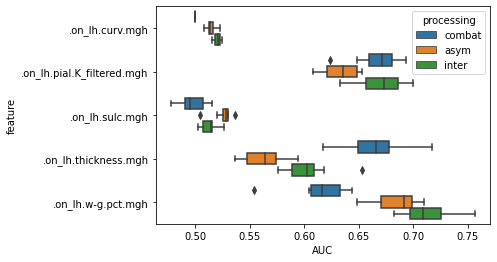

In [58]:
# bring stats in right format for plotting
df = pd.melt(stats, id_vars='processing', var_name='feature', value_name='AUC') # value_vars=keys, value_name='key')
sns.boxplot(data=df, y='feature', x='AUC', hue='processing')

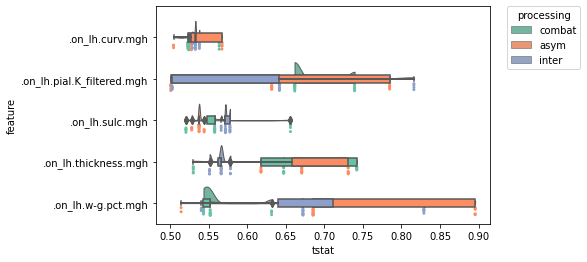

In [231]:
import ptitprince as pt

ax = pt.RainCloud(y = 'tstat', x = 'feature', hue='processing',
                  data = df, 
                  width_viol = .8,
                  width_box = .2,
                   orient = 'h',
                  move = .2,
                  offset=0)